In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from collections import Counter
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import math
import torch

from torch import nn
from torch.utils.data import Dataset

In [7]:
# Load the data
class Dataset(Dataset):
    def __init__(self, path):
        self.load_data = pd.read_csv(path, encoding='ISO-8859-1')
    
    def __len__(self):
        return len(self.load_data)
    
    def __getitem__(self):
        return self.load_data

root = '/content/drive/MyDrive/Program/Python/Data ML DL/Datasets/US  E-commerce records 2020.csv'
load_data = Dataset(root)

In [8]:
dataframe = pd.DataFrame(
    {'date': load_data.__getitem__()['Order Date'],
    'counts': load_data.__getitem__()['Sales'],}
)
dataframe['date'] = pd.to_datetime(dataframe['date'])
dataframe = dataframe.sort_values(by='date')
dataframe = dataframe.set_index('date')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3312 entries, 2020-01-01 to 2020-12-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   counts  3312 non-null   float64
dtypes: float64(1)
memory usage: 51.8 KB


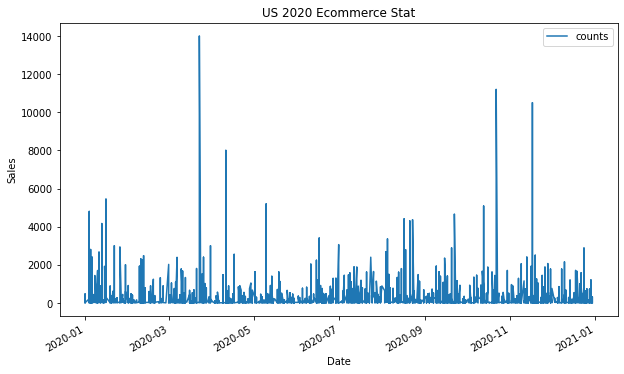

In [10]:
dataframe.fillna(method='pad')
dataframe.plot(figsize=(10,6), subplots=True)

plt.title('US 2020 Ecommerce Stat')
plt.ylabel('Sales')
plt.xlabel('Date')

dataframe.info()

In [11]:
dataframe = dataframe.fillna(method='ffill')
scaler = MinMaxScaler(feature_range=(-1, 1))
dataframe['counts'] = scaler.fit_transform(dataframe['counts'].values.reshape(-1, 1))

In [12]:
def load_data(dataframe, look_back):
    data_raw = dataframe.values
    data = []

    for index in range(len(data_raw) - look_back):
        data.append(data_raw[index:index+look_back])
    
    data = np.array(data)
    test_set_size = int(np.round(0.2*data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)

    x_train = data[:train_set_size, :-1]
    y_train = data[:train_set_size, -1]

    x_test = data[train_set_size:, :-1]
    y_test = data[train_set_size:, -1]

    return [x_train, y_train, x_test, y_test]

look_back = 10
x_train, y_train, x_test, y_test = load_data(dataframe, look_back)

print(f'x_train.shape = {x_train.shape}')
print(f'y_train.shape = {y_train.shape}')
print(f'x_test.shape = {x_test.shape}')
print(f'y_test.shape = {y_test.shape}')

x_train.shape = (2642, 9, 1)
y_train.shape = (2642, 1)
x_test.shape = (660, 9, 1)
y_test.shape = (660, 1)


In [13]:
x_train_to_tensor = torch.from_numpy(x_train).type(torch.Tensor)
x_test_to_tensor = torch.from_numpy(x_test).type(torch.Tensor)
y_train_to_tensor = torch.from_numpy(y_train).type(torch.Tensor)
y_test_to_tensor = torch.from_numpy(y_test).type(torch.Tensor)

x_train_to_tensor.size(), y_train_to_tensor.size()

(torch.Size([2642, 9, 1]), torch.Size([2642, 1]))

In [14]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        #hidden dimension
        self.hidden_dim = hidden_dim

        #numbers of hidden layer
        self.num_layers = num_layers

        #batch_first=True causes input/output tensors to be out of shape
        #(batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        #read out layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # initialize hidden states with zero
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # initialize cell states
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Index hidden state of last time step
        # out.size() --> 100, 32, 100
        # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
        out = self.fc(out[:, -1, :]) 
        # out.size() --> 100, 10
        return out

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
print(model)
print(len(list(model.parameters())))

for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
10
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


In [15]:
# Train model
epochs = 100
hist = np.zeros(epochs)

seq_dim = look_back-1
for epoch in range(epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass
    y_train_pred = model(x_train_to_tensor)

    loss = loss_fn(y_train_pred, y_train_to_tensor)
    if epoch % 10 == 0 and epoch !=0:
        print("Epoch ", epoch, "MSE: ", loss.item())
    hist[epoch] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimizer.step()

Epoch  10 MSE:  0.06033071130514145
Epoch  20 MSE:  0.017448844388127327
Epoch  30 MSE:  0.01109438668936491
Epoch  40 MSE:  0.008636186830699444
Epoch  50 MSE:  0.007741495501250029
Epoch  60 MSE:  0.0074098301120102406
Epoch  70 MSE:  0.007285410538315773
Epoch  80 MSE:  0.0072423177771270275
Epoch  90 MSE:  0.007232686039060354


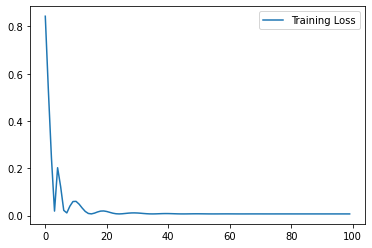

In [16]:
plt.plot(hist, label='Training Loss')
plt.legend()
plt.show()

In [17]:
np.shape(y_train_pred)

torch.Size([2642, 1])

In [18]:
y_test_pred = model(x_test_to_tensor)
y_test_pred.shape

torch.Size([660, 1])

In [19]:
# make predictions
y_test_pred = model(x_test_to_tensor)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_to_tensor.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_to_tensor.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 595.28 RMSE
Test Score: 547.20 RMSE


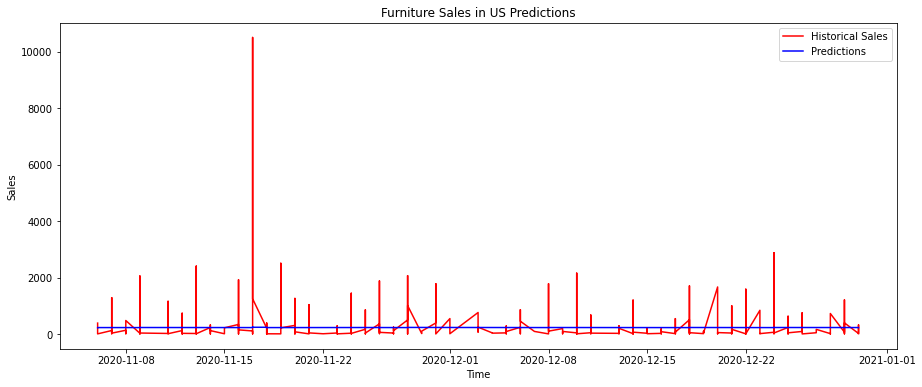

In [23]:
# Visualising the results
figure, axes = plt.subplots(figsize=(15, 6))
axes.xaxis_date()

axes.plot(dataframe[len(dataframe)-len(y_test):].index, y_test, color='red', label='Historical Sales')
axes.plot(dataframe[len(dataframe)-len(y_test):].index, y_test_pred, color='blue', label='Predictions')
#axes.xticks(np.arange(0,394,50))

plt.title('Furniture Sales in US Predictions')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.legend()
plt.savefig('ibm_pred.png')
plt.show()